**Satisfying Requirements**


In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install natsort==7.1.0 Pillow==8.0.1 gdown

Looking in links: https://download.pytorch.org/whl/torch_stable.html


**Importing Required Libraries**

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
#import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib import image
import math
import numpy
import random
%matplotlib inline


In [ ]:
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [ ]:
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

device

device(type='cuda', index=0)

**Some other Requirements**

In [ ]:
from torchvision import transforms, datasets
import os
import zipfile

import gdown

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image

**Downloading the Dataset**

In [ ]:
# Root directory for the celebset dataset
data_root = 'data/celebset'
# Path to folder with individual images
img_folder1 = f'{data_root}/img_celebset'
# URL for the Celebset dataset
url = "https://drive.google.com/uc?id=1EGVVqy9ZUVg4ErPlgEGQuezDkcMPJBSh"
# Path to download the dataset to
download_path = f'{data_root}/img_celebset.zip'
# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(img_folder1)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(img_folder1)

Downloading...
From: https://drive.google.com/uc?id=1EGVVqy9ZUVg4ErPlgEGQuezDkcMPJBSh
To: /content/data/celebset/img_celebset.zip
11.0MB [00:00, 37.4MB/s]


**Creating a Class to handle Celebset dataset**

In [ ]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

**Image Transformation and Dataset Loading**

In [ ]:
# Spatial size of training images, images are resized to this size.
image_size = 32
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

inv_normalize =  transforms.Normalize(
    mean=[-1, -1, -1],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# Load the dataset from file and apply transformations
celebset_dataset= CelebADataset(f'{img_folder1}/img_celebset', transform)

**Mounting the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Mapping ground truth to image instances**

In [ ]:
import pandas as pd
attributes1 = pd.read_csv('/content/drive/My Drive/Celebset1_dataset/list_attr_celebset.csv')

y1=attributes1['male']
y_names=attributes1['filename']

idx_male=[]
idx_female=[]
for i in range(1600):
  if y1[i]==0:
    idx_female.append(i)
  else:
    idx_male.append(i)


**Creating encoder and decoder**

In [ ]:
classes = ('Male','Female')

decoder = {}
decoder['Male'] = 1
decoder['Female'] = 0

encoder = {}
encoder[1] = 'Male'
encoder[0] = 'Female'

**Loading the PreActResNet18 model from drive**

In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/pytorch-cifar-master')

import models
from models import *
load_model=True

In [ ]:
net = PreActResNet18()

**ResnetCode**

In [ ]:
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

"""

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
net = net.to(device)
#if device == 'cuda':
#    net = torch.nn.DataParallel(net)
#    cudnn.benchmark = True
device

'cuda'

**Defining Optimizer and Loss criterion**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def load_checkpoint(check_point,map_location='cpu'):
  print("=> loading check_point")
  net.load_state_dict(check_point['net'])
  optimizer.load_state_dict(check_point['optimizer'])

**Creating Test set manually**

In [ ]:
test_inddex=[1, 2, 13, 14, 16, 17, 18, 20, 41, 42, 43, 44, 45, 49, 50, 54, 55, 56, 57, 58, 61, 63, 65, 67, 68, 70, 72, 74, 75, 76, 77, 79, 80, 201, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 240, 241, 242, 243, 244, 5, 25, 81, 123, 133, 134, 149, 152, 165, 172, 221, 265, 266, 267, 270, 277, 305, 306, 307, 309, 316, 354, 380, 382, 385, 390, 419, 420, 421, 424, 425, 429, 431, 436, 463, 464, 477, 483, 489, 495, 521, 524, 567, 720, 721, 750, 755, 756, 760, 763]
final_test_set=[]
for i in test_inddex:
  final_test_set.append((celebset_dataset.__getitem__(i),y1[i]))

final_testloader = torch.utils.data.DataLoader(final_test_set, batch_size=10,
                                          shuffle=False, num_workers=8)

**Preparing data for stratified K-fold cross-validation**

In [ ]:
# Preparing data for stratified K-fold cross-validation
from sklearn.model_selection import StratifiedKFold
dataset_X=[]
dataset_y=[]
map_index=[]
for i in range(1600):
  if i not in test_inddex:
    dataset_X.append(celebset_dataset.__getitem__(i))
    dataset_y.append(y1[i])
    map_index.append(i)
    

print(len(dataset_y))
skf = StratifiedKFold(n_splits=10)
print(skf.get_n_splits(dataset_X, dataset_y))
print(skf)

1500
10
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


**Defining Train Function**

In [ ]:
def train(epoch,net,optimizer):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    return net

**Defining Test Function**

In [ ]:
def test(epoch,fold_no,net):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    wrong_pred=[]
    right_pred=[]
    true=[]
    pred=[]
    image=[]
    true_c=[]
    pred_c=[]
    image_c=[]
    true_all=[]
    pred_all=[]
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(final_testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
           
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            # print('predicted:',predicted)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            print(batch_idx, len(final_testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            for i in range(len(predicted)):
                pred_all.append(predicted[i])
                true_all.append(targets[i])
                if(predicted[i]!=targets[i]):
                    true.append(targets[i])
                    pred.append(predicted[i])
                    wrong_pred.append(batch_idx*32+i)
                #pred_wrong.append(preds[i])
                #true_wrong.append(target[i])
                    image.append(inputs[i])
                else:
                    true_c.append(targets[i])
                    pred_c.append(predicted[i])
                    right_pred.append(batch_idx*32+i)
                    image_c.append(inputs[i])
            
    print(wrong_pred)
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'optimizer':optimizer.state_dict(),
        }
        
        torch.save(state, '/content/drive/My Drive/genderclassifier_new_'+str(fold_no*10)+'.pth')
        best_acc = acc
    return true,pred,wrong_pred,image,pred_all,true_c,pred_c,right_pred,image_c,true_all

**Storing the Test, Train and Validation set indices for each fold**

In [ ]:
fold_no=1
with open('/content/drive/My Drive/test_train_valid.txt', 'a') as writefile:
  writefile.write("TEST: "+ ' '.join(map(str, test_inddex))+ "\n")
for train_index, test_index in skf.split(dataset_X, dataset_y):
  train_index_map=[]
  test_index_map=[]
  for i in train_index.tolist():
    train_index_map.append(map_index[i])
  for j in test_index.tolist():
    test_index_map.append(map_index[j])
  #print("Fold ",fold_no)
  #print("TRAIN:", train_index_map, "\nTEST:", test_index_map)
  with open('/content/drive/My Drive/test_train_valid.txt', 'a') as writefile:
    writefile.write("Fold"+ str(fold_no)+ "\n")
    writefile.write("TRAIN:"+ ' '.join(map(str, train_index_map))+"\n"  + "VALID:"+ ' '.join(map(str, test_index_map)) +"\n")
  fold_no+=1

Fold  1
TRAIN: [132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 259, 260, 261, 262, 263, 264, 268, 269, 271, 272, 273, 274, 275, 276, 278, 299, 300, 301, 302, 303, 304, 308, 310, 311, 312, 313, 314, 315, 317, 318, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 381, 383, 384, 386, 387, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 422, 423, 426, 427,

**Applying K-fold cross validation**

In [ ]:
# Applying K-fold cross validation
fold_no=1
results=[]
indices=[]
for train_index, test_index in skf.split(dataset_X, dataset_y):
  net = PreActResNet18()
  net = net.to(device)
  optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
  print("Fold ",fold_no)
  print("TRAIN:", train_index, "TEST:", test_index)

  #Creating Training and validation set for the fold
  indices.append([train_index,test_index])
  tn_set=[]
  tt_set=[]
  for j in train_index:
    tn_set.append((dataset_X[j],dataset_y[j]))
  for j in test_index:
    tt_set.append((dataset_X[j],dataset_y[j]))

  #Creating train loader and test loader for the fold
  trainloader = torch.utils.data.DataLoader(tn_set, batch_size=30,
                                          shuffle=False, num_workers=8)
  testloader = torch.utils.data.DataLoader(tt_set, batch_size=30,
                                          shuffle=False, num_workers=8)
  
  #Train a model on the particular fold
  for epoch in range(70):
    net=train(epoch,net,optimizer)
    test(epoch,fold_no,net)
    scheduler.step()
  
  #Test the trained model on the validation set of the fold
  true,pred,wrong_pred,image,pred_all,true_c,pred_c,right_pred,image_c,true_all=test(epoch,fold_no,net)

  #Creating the actual and predicted label vectors
  y_true=[]
  y_pred=[]
  for i in test_index:
    y_true.append(dataset_y[i])
  for i in range(len(pred_all)):
    y_pred.append(pred_all[i].item())
  #print(true_all)

  # Evaluating confusion matrix and other performance measures
  import sklearn
  from sklearn.metrics import confusion_matrix
  cm=confusion_matrix(y_true,y_pred,labels=[0,1])
  print("Results of fold ",fold_no)
  print(cm)
  acc_m=cm[1][1]/(sum(cm[1]))
  acc_f=cm[0][0]/sum(cm[0])
  acc_all=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
  eval_stats=sklearn.metrics.precision_recall_fscore_support(y_true,y_pred)
  results.append([cm,acc_m,acc_f,acc_all,eval_stats])
  print('Accuracy(Male)=',acc_m)
  print('Accuracy(Female)=',acc_f)
  print('Overall Accuracy=',acc_all)
  print(eval_stats)
  fold_no+=1

Fold  1
TRAIN: [  95   96   97 ... 1497 1498 1499] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94 158 159 160 161 162 163 164 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 248 249 250 251 252 253 254 255
 256 257 258 259 260 261]

Epoch: 0
0 45 Loss: 0.860 | Acc: 0.000% (0/30)
1 45 Loss: 0.444 | Acc: 50.000% (30/60)
2 45 Loss: 0.296 | Acc: 66.667% (60/90)
3 45 Loss: 0.762 | Acc: 70.000% (84/120)
4 45 Loss: 1.604 | Acc: 67.333% (101/150)
5 45 Loss: 1.554 | Acc: 69.444% (125/180)
6 45 Loss: 1.598 | Acc: 70.476% (148/210)
7 45 Loss: 1.504 | Acc: 68.750% (165/2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
18 45 Loss: 0.728 | Acc: 44.737% (255/570)
19 45 Loss: 0.740 | Acc: 42.833% (257/600)
20 45 Loss: 0.731 | Acc: 45.238% (285/630)
21 45 Loss: 0.717 | Acc: 47.727% (315/660)
22 45 Loss: 0.716 | Acc: 47.826% (330/690)
23 45 Loss: 0.711 | Acc: 48.611% (350/720)
24 45 Loss: 0.716 | Acc: 47.600% (357/750)
25 45 Loss: 0.709 | Acc: 48.974% (382/780)
26 45 Loss: 0.699 | Acc: 50.864% (412/810)
27 45 Loss: 0.697 | Acc: 51.190% (430/840)
28 45 Loss: 0.700 | Acc: 50.920% (443/870)
29 45 Loss: 0.703 | Acc: 50.444% (454/900)
30 45 Loss: 0.705 | Acc: 50.215% (467/930)
31 45 Loss: 0.705 | Acc: 50.000% (480/960)
32 45 Loss: 0.699 | Acc: 51.111% (506/990)
33 45 Loss: 0.696 | Acc: 52.157% (532/1020)
34 45 Loss: 0.701 | Acc: 51.048% (536/1050)
35 45 Loss: 0.702 | Acc: 50.648% (547/1080)
36 45 Loss: 0.703 | Acc: 50.090% (556/1110)
37 45 Loss: 0.693 | Acc: 51.404% (586/1140)
38 45 Loss: 0.692 | Acc: 51.111% (598/1170)
39 45 Loss: 0.689 | Acc: 52.250% (627/12

**Printing Results for each fold**

In [ ]:
for i in range(10):
  print(results[i])

[array([[75,  0],
       [75,  0]]), 0.0, 1.0, 0.5, (array([0.5, 0. ]), array([1., 0.]), array([0.66666667, 0.        ]), array([75, 75]))]
[array([[73,  2],
       [46, 29]]), 0.38666666666666666, 0.9733333333333334, 0.68, (array([0.61344538, 0.93548387]), array([0.97333333, 0.38666667]), array([0.75257732, 0.54716981]), array([75, 75]))]
[array([[72,  3],
       [29, 46]]), 0.6133333333333333, 0.96, 0.7866666666666666, (array([0.71287129, 0.93877551]), array([0.96      , 0.61333333]), array([0.81818182, 0.74193548]), array([75, 75]))]
[array([[73,  2],
       [69,  6]]), 0.08, 0.9733333333333334, 0.5266666666666666, (array([0.51408451, 0.75      ]), array([0.97333333, 0.08      ]), array([0.67281106, 0.14457831]), array([75, 75]))]
[array([[67,  8],
       [11, 64]]), 0.8533333333333334, 0.8933333333333333, 0.8733333333333333, (array([0.85897436, 0.88888889]), array([0.89333333, 0.85333333]), array([0.87581699, 0.8707483 ]), array([75, 75]))]
[array([[74,  1],
       [58, 17]]), 0.22

**Loading model if the model is already trained and saved in drive**

In [ ]:
# If model is already trained
if load_model:
  load_checkpoint(torch.load('/content/drive/My Drive/genderclassifier_new_3.pth',map_location='cpu'))

=> loading check_point


**Training the model from Scratch (needed only if pre-trained model is unavailable)**

In [ ]:
# If pre-trained model is unavailable
for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)
    scheduler.step()

**Testing the model corresponding to the fold with maximum accuracy on the test set**

In [ ]:
#Load the model corrsponding to the fold with maximum accuracy on the test set
#i=3 corresponds to the model trained on 3rd fold
i=3
if load_model:
  load_checkpoint(torch.load('/content/drive/My Drive/genderclassifier_new_'+str(i)+'.pth',map_location='cpu'))

#Testing the model
epoch=range(10)
true,pred,wrong_pred,image,pred_all,true_c,pred_c,right_pred,image_c,true_all=test(epoch,i,net)

#Creating the actual and predicted label vectors
y_true=[]
y_pred=[]
for i in test_inddex:
  y_true.append(y1[i])
for i in range(len(pred_all)):
  y_pred.append(pred_all[i].item())

# Getting Confusion Matrix
import sklearn
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred,labels=[0,1])
print(cm)

#Calculating performance measures
acc_m=cm[1][1]/(sum(cm[1]))
acc_f=cm[0][0]/sum(cm[0])
acc_all=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
eval_stats=sklearn.metrics.precision_recall_fscore_support(y_true,y_pred)

print('Accuracy(Male)=',acc_m)
print('Accuracy(Female)=',acc_f)
print('Overall Accuracy=',acc_all)
print(eval_stats)

=> loading check_point
0 10 Loss: 0.265 | Acc: 80.000% (8/10)
1 10 Loss: 0.135 | Acc: 90.000% (18/20)
2 10 Loss: 0.180 | Acc: 90.000% (27/30)
3 10 Loss: 0.200 | Acc: 90.000% (36/40)
4 10 Loss: 0.541 | Acc: 88.000% (44/50)
5 10 Loss: 0.468 | Acc: 90.000% (54/60)
6 10 Loss: 0.514 | Acc: 90.000% (63/70)
7 10 Loss: 0.541 | Acc: 87.500% (70/80)
8 10 Loss: 0.494 | Acc: 87.778% (79/90)
9 10 Loss: 0.502 | Acc: 87.000% (87/100)
[1, 7, 68, 99, 135, 137, 193, 226, 228, 230, 256, 288, 290]
Saving..
[[44  6]
 [ 7 43]]
Accuracy(Male)= 0.86
Accuracy(Female)= 0.88
Overall Accuracy= 0.87
(array([0.8627451 , 0.87755102]), array([0.88, 0.86]), array([0.87128713, 0.86868687]), array([50, 50]))


**Defining a function to visualize the images with their predicted and actual labels**

In [ ]:
def wrong_plot(true,ima,pred,encoder,n_figures = 20):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for (ax,a) in zip(axes.flatten(),range(20)):
        
    
        image,correct,wrong = ima[a],true[a],pred[a]
        
        #image = torch.from_numpy(image.numpy())
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        
        image = inv_normalize(image)
        image = image.cpu().numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()

Classes in order Actual and Predicted


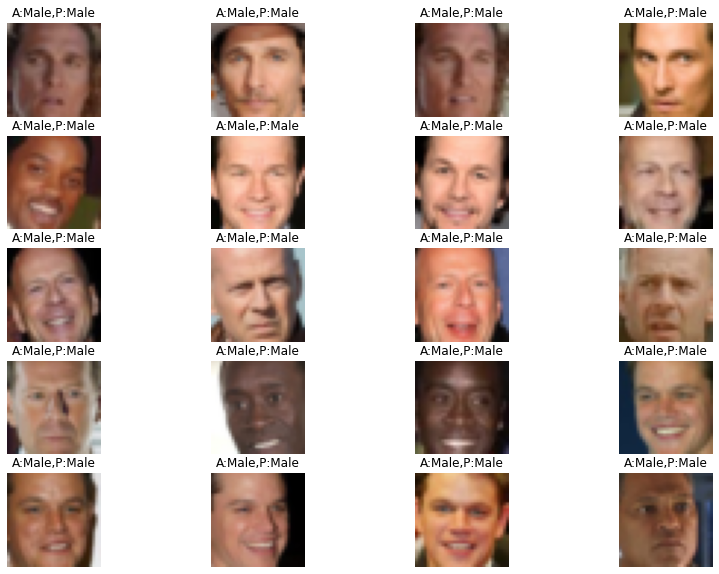

In [ ]:
#Visualize the images 
wrong_plot(true_c[60:80],image_c[60:80],pred_c[60:80],encoder)

**Input images to Grad-CAM**

In [ ]:
pictures=image[:13]

**Applying Grad-CAM to produce heat maps and superimposed images**

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import collections
 
def load_checkpoint(check_point):
  print("=> loading check_point")
  net.load_state_dict(check_point['net'])
  optimizer.load_state_dict(check_point['optimizer'])
 
# ResNet Class
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the PreActResNet18
        self.resnet = PreActResNet18()
        #load the PreActResNet18

        model_dic = torch.load('/content/drive/My Drive/genderclassifier_new_3.pth')                
        #Load the model which is used to test
        new_net_dict = collections.OrderedDict()
        new_state_dict = collections.OrderedDict()

        for k,v in model_dic.items():
            print(k)
        for k, v in model_dic['net'].items():
            name=k.replace('module.','')
            new_net_dict[name]=v
        new_state_dict['net']=new_net_dict 
        new_state_dict['acc']=model_dic['acc']
        new_state_dict['epoch']=model_dic['epoch']
        new_state_dict['optimizer']=model_dic['optimizer'] 
        self.resnet.load_state_dict(new_state_dict['net'])
        optimizer.load_state_dict(new_state_dict['optimizer'])
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
       
        
        # classifier
        self.classifier = self.resnet.linear
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        x=F.avg_pool2d(x, 4)
        # complete the forward pass
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        
        return x
 
      
# all the data transformation and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = final_test_set
dataloader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)
 
# init the resnet
resnet = ResNet()
 
# set the evaluation mode
_ = resnet.eval()
 
 
 
# ###############################################################
for i,k in zip(pictures,range(20)):
    i=i.cpu().reshape(1,3,32,32)
    pred=resnet(i)
    index=pred.argmax(dim=1)
    
    pred[:,index].backward()
    gradients = resnet.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = resnet.get_activations(i).detach()
    for j in range(512):
        activations[:, j, :, :] *= pooled_gradients[j]
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    plt.matshow(heatmap.squeeze())
    heatmap = heatmap.numpy()
    i=inv_normalize(i)
    i=i.reshape(3,32,32)
    i=i.numpy().transpose(1,2,0)
    i=np.uint8(255*i)
    i=cv2.resize(i,(224,224))
    file_name1='./im'+str(k)+'.jpg'
    cv2.imwrite(file_name1, i)
    
    q=plt.imshow(i)
    heatmap = cv2.resize(heatmap, (i.shape[1], i.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    f2='./heatmap'+str(k)+'.jpg'
    cv2.imwrite(f2,heatmap)
    superimposed_img = heatmap*0.7  + i
    #plt.imshow(superimposed_img)
    file_name='./map'+str(k)+'.jpg'
    cv2.imwrite(file_name, superimposed_img)


In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the PreActResNet18
        self.resnet = PreActResNet18()
        #load the PreActResNet18

        model_dic = torch.load('/content/drive/My Drive/genderclassifier_new_3.pth')                
        #Load the model which is used to test
        new_net_dict = collections.OrderedDict()
        new_state_dict = collections.OrderedDict()

        for k,v in model_dic.items():
            print(k)
        for k, v in model_dic['net'].items():
            name=k.replace('module.','')
            new_net_dict[name]=v
        new_state_dict['net']=new_net_dict 
        new_state_dict['acc']=model_dic['acc']
        new_state_dict['epoch']=model_dic['epoch']
        new_state_dict['optimizer']=model_dic['optimizer'] 
        self.resnet.load_state_dict(new_state_dict['net'])
        optimizer.load_state_dict(new_state_dict['optimizer'])
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
       
        
        # classifier
        self.classifier = self.resnet.linear
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        x=F.avg_pool2d(x, 4)
        # complete the forward pass
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        
        return x
 
      

In [ ]:
# all the data transformation and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = final_test_set
dataloader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)
 
# init the resnet
resnet = ResNet()
 
# set the evaluation mode
_ = resnet.eval()